In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from factor_analyzer import FactorAnalyzer
from sklearn.cluster import KMeans

import pyreadstat
import researchpy as rp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def multi_ttest_1d(df, segment, variable, alpha= 0.05, violinplot= False):
    # 1. Returns the results of t_tests for the independent samples (mean): 
    #    segment is the independent (grouping) variable and variable contains dependent (test) variables
    # 2. Returns a violin plot at the end to illustrate the difference of samples in each segment
    #
    # Parameter df: the dataframe to be analyzed
    # Precondition: df is a dataframe
    #
    # Parameter segment: a column name (string) of segments from df
    # Precondition: segment is in df; segment is non-metric; data in segment starts from 0 and contains only integers;
    #               the maximum value of segment > 0 (i.e., there are more than 1 segments in df)
    #
    # Parameter variable: a column name (string) of test variable from df
    # Precondition: variable is in df; variable is metric
    #
    # Parameter alpha: decision rule to reject the null hypothesis (default= 0.05)
    # Precondition: alpha is a float > 0 and < 1
    #
    # Parameter violinplot: a boolean indicating whether the function return a violinplot. 
    #                       If violinplot == False, the function returns a boxplot
    # Precondition: violinplot is a boolean, default= True

    seg_min= df[segment].min()
    seg_max= df[segment].max()
    
    for a in range(seg_min, seg_max):
        for b in range(a+1, seg_max+1):
            ttest_helper(df, segment, a, b, variable, alpha)
            if (a < seg_max-1) or (b < seg_max):
                print('\n')

    plt.subplot()
    if violinplot == True:
        sns.violinplot(x= segment, y= variable, data= df)
    else:
        sns.boxplot(x= segment, y= variable, data= df)
    plt.show()

In [3]:
def ttest_helper(df, segment, a, b, variable, alpha= 0.05): 
    # Returns the results of t_tests for the independent samples (mean of variable) 
    # between segment == a and segment == b
    #
    # Parameter df: the dataframe to be analyzed
    # Precondition: df is a dataframe
    #
    # Parameter segment: a column name (string) of segments from df
    # Precondition: segment is in df; segment is non-metric; data in segment starts from 0 and contains only integers;
    #               the maximum value of segment > 0 (i.e., there are more than 1 segments in df)
    #
    # Parameter a: an integer in segment
    # Precondition: a != b
    #
    # Parameter b: an integer in segment
    # Precondition: b != a
    #
    # Parameter variable: a column name (string) of test variable from df
    # Precondition: variable is in df; variable is metric
    #
    # Parameter alpha: decision rule to reject the null hypothesis (default = 0.05)
    # Precondition: alpha is a float > 0 and < 1
    
    seg_a= df[variable].loc[df[segment] == a]
    seg_b= df[variable].loc[df[segment] == b]
    t_stat, p_value= stats.ttest_ind(seg_a, seg_b)
        
    if p_value > alpha:
        print('Segments %i vs. %i: no difference (fail to reject H0)' % (a, b))
    else:
        print('Segments %i vs. %i: the difference is statistically significant (reject H0)' % (a, b))
                    
    print('mean of %s when (%s = %i): %.3f, N: %i' % (variable, segment, a, seg_a.mean(), seg_a.count()))             
    print('mean of %s when (%s = %i): %.3f, N: %i' % (variable, segment, b, seg_b.mean(), seg_b.count()))    
    print('p-value of the difference: %.3f' % p_value)

In [4]:
def fa_adequacy_test(df):
    # 1. Return a boolean and a detail (str or int), indicating whether the dataframe df is adequate for factor analysis, 
    #    using Bartlett’s Test (with alpha <= 0.05) and Kaiser-Meyer-Olkin test (with KMO > 0.6), 
    #    i.e. "Can we find factors from the observed variables (the columns in the df)?"
    # 2. The detail constains a suggested number of factors if df passes the test, using the Kaiser criterion.
    # 3. The detail contains reasons if df does not pass the test.
    #
    # Parameter df: dataframe to be analyzed
    # Precondition: df is a dataframe, containing the observed variables
    
    error_msg= ''
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
    chi_square_value, p_value_bs= calculate_bartlett_sphericity(df)
    if p_value_bs > 0.05:
        error_msg= 'df does not pass Bartlett’s test (p-value > 0.05)'
        return False, error_msg
    
    from factor_analyzer.factor_analyzer import calculate_kmo
    kmo_all, kmo_model= calculate_kmo(df)
    if kmo_model < 0.6:
        error_msg= 'df does not pass Kaiser-Meyer-Olkin test (KMO < 0.6)'
        return False, error_msg
    
    n_factors= num_of_factors(df)
    return True, n_factors

In [5]:
def num_of_factors(df, scree_plot= False, eigenvalue= False):
    # Returns a suggested number of factors using Kaiser criterion (min # of factors whose eigenvalue > 1)
    # and an optional scree plot
    #
    # Parameter df: dataframe to be analyzed
    # Precondition: df is a dataframe, containing the observed variables
    #
    # Parameter scree_plot: a boolean indicating whether the returned values include a scree plot
    # Precondition: a boolean, default = False (no plot)
    #
    # Parameter eigenvalue: a boolean indicating whether the returned values include an array of eigenvalues
    # Precondition: a boolean, default = False (no eigenvalues returned)
    
    # Create factor analysis object and perform factor analysis
    fa = FactorAnalyzer(n_factors= df.shape[1], rotation= None)    
    fa.fit(df)

    ev, v = fa.get_eigenvalues()    
    num_of_factor= 0
    for a in range(0, len(ev)):
        if ev[a] > 1:
            num_of_factor+= 1

    if scree_plot == False:
        if eigenvalue == False:
            return num_of_factor
        else:
            return num_factor, ev
    else:
        plt.scatter(range(1, df.shape[1]+1), ev)
        plt.plot(range(1, df.shape[1]+1), ev)
        plt.title('Scree Plot')
        plt.xlabel('Factors')
        plt.ylabel('Eigenvalue')
        plt.grid()
        plt.show() 
        if eigenvalue == False:
            return num_of_factor
        else:     
            return num_of_factor, ev

In [6]:
def factor_analysis(df):
    # Returns the factor variance info of factor analysis (rotation= 'varimax') of df and transformed df, 
    # if df passes the adequecy test
    # Returns the reason if df does not pass the adequecy test
    #
    # Parameter df: dataframe to be analyzed
    # Precondition: df is a dataframe, containing the observed variables
    
    result, detail= fa_adequacy_test(df)
    if result == True:
        fa= FactorAnalyzer(n_factors= detail, rotation= 'varimax', method= 'principal') 
        fa.fit(df)
        
        factor_col_names= ['Factor'+str(i+1) for i in range(0, detail)]
        tranform= fa.transform(df)      
        transform_df= pd.DataFrame(data= tranform[0:,0:],
                                   index= [i for i in range(tranform.shape[0])],
                                   columns= factor_col_names)
        loadings= pd.DataFrame(data= fa.loadings_, index= df.columns, columns= factor_col_names)
        return fa.get_factor_variance(), loadings, transform_df
    else:
        return detail, 'N/A'

In [7]:
def elbow_KMean(df):
    # Returns a plot of number of clusters of KMean vs. the sum of squared distances for elbow method
    #
    # Parameter df: the dataframe to be classified using KMean
    # Precondition: df is a dataframe
    
    Sum_of_squared_distances = []
    k_clusters = np.arange(1, 11)
    for k in k_clusters:
        km_models = KMeans(k).fit(df)
        Sum_of_squared_distances.append(km_models.inertia_)

    plt.scatter(k_clusters, Sum_of_squared_distances)
    plt.plot(k_clusters, Sum_of_squared_distances)
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.grid()
    plt.show() 

In [8]:
def cluster_analysis(df, n_cluster, starting_factor= 'Factor1', ending_factor= 'Factor2', label= True):
    # Returns a scatter plot of the KMean result from factor1 and factor2
    # The function adds a new column 'Segment' + str(n_cluster) with labels from KMean classification
    #
    # Parameter df: dataframe to be analyzed
    # Precondition: df is a dataframe, containing columns factor1 and factor2
    #
    # Parameter n_cluster: number of clusters for KMean classification
    # Precondition: n_cluster is an integer < 20
    #
    # Parameter starting_factor: the starting column name (string) of test variable from df (default: 'Factor1')
    # Precondition: factor1 is in df, containing metric variable
    #
    # Parameter ending_factor: the ending column name (string) of test variable from df (default: 'Factor2')
    # Precondition: factor2 is in df, all columns (inclusively) between starting_factor and ending_factor contain 
    #               only metric variable and are all factors to be used for cluster analysis
    #
    # Parameter label: a boolean indicating whether to add a new column indicating the labels 
    #                  from Kmean classification to df
    # Precondition: label is a boolean, default = True
    
    kmeans= KMeans(n_clusters= n_cluster)
    kmeans.fit(df.iloc[:, df.columns.get_loc(starting_factor):df.columns.get_loc(ending_factor)+1])
    
    if label == True:
        n_segment= 'Segment' + str(n_cluster)
        df[n_segment]= kmeans.labels_

In [9]:
df, meta= pyreadstat.read_sav('DuPont_2FA_3Seg.sav')
df.head()

,WTE,Expint3,Expint2,Size,Revenue,Years,Numprod,Q1,Q2,Q3,...,FAC3_2,FAC4_2,QCL_1,QCL_2,QCL_3,QCL_4,QCL_5,QCL_6,QCL_7,QCL_8
0,5.0,3.0,1.0,54.0,4.0,6.5,7.0,8.0,8.0,5.0,...,0.395237,-1.524003,1.0,1.449672,3.0,1.676915,2.0,1.753951,1.0,1.619457
1,3.0,2.0,0.0,45.0,2.0,6.0,6.0,9.0,9.0,9.0,...,-0.350117,1.054981,2.0,1.015106,2.0,1.236237,2.0,1.250457,1.0,1.462076
2,2.0,1.0,0.0,44.0,2.0,5.8,11.0,10.0,4.0,2.0,...,2.850401,-2.555845,1.0,4.544876,3.0,4.653000,1.0,1.866429,3.0,0.000000
3,4.0,3.0,1.0,46.0,1.0,7.0,3.0,8.0,8.0,10.0,...,1.384838,-2.185621,1.0,2.776540,3.0,3.287898,2.0,3.790690,1.0,3.527590
4,5.0,3.0,1.0,46.0,3.0,6.5,8.0,9.0,9.0,7.0,...,-0.262135,-0.642676,2.0,0.799588,2.0,0.768550,2.0,0.809775,1.0,0.644879


In [10]:
df= df.rename(columns={'FAC1_1': 'Factor1_19v', 'FAC2_1': 'Factor2_19v', 'FAC3_1': 'Factor3_19v', 'FAC4_1': 'Factor4_19v', 
                       'FAC1_2': 'Factor1_18v', 'FAC2_2': 'Factor2_18v', 'FAC3_2': 'Factor3_18v', 'FAC4_2': 'Factor4_18v', 
                       'QCL_1': 'Segment2_19v', 'QCL_2': 'Centroid2_19v','QCL_3': 'Segment3_19v', 'QCL_4': 'Centroid3_19v', 
                       'QCL_5': 'Segment2_18v', 'QCL_6': 'Centroid2_18v', 'QCL_7': 'Segment3_18v', 'QCL_8': 'Centroid3_18v'})
df['Segment2_19v']= df['Segment2_19v'].astype(int)
df['Segment3_19v']= df['Segment3_19v'].astype(int)
df['Segment2_18v']= df['Segment2_18v'].astype(int)
df['Segment3_18v']= df['Segment3_18v'].astype(int)
df.head()

,WTE,Expint3,Expint2,Size,Revenue,Years,Numprod,Q1,Q2,Q3,...,Factor3_18v,Factor4_18v,Segment2_19v,Centroid2_19v,Segment3_19v,Centroid3_19v,Segment2_18v,Centroid2_18v,Segment3_18v,Centroid3_18v
0,5.0,3.0,1.0,54.0,4.0,6.5,7.0,8.0,8.0,5.0,...,0.395237,-1.524003,1,1.449672,3,1.676915,2,1.753951,1,1.619457
1,3.0,2.0,0.0,45.0,2.0,6.0,6.0,9.0,9.0,9.0,...,-0.350117,1.054981,2,1.015106,2,1.236237,2,1.250457,1,1.462076
2,2.0,1.0,0.0,44.0,2.0,5.8,11.0,10.0,4.0,2.0,...,2.850401,-2.555845,1,4.544876,3,4.653000,1,1.866429,3,0.000000
3,4.0,3.0,1.0,46.0,1.0,7.0,3.0,8.0,8.0,10.0,...,1.384838,-2.185621,1,2.776540,3,3.287898,2,3.790690,1,3.527590
4,5.0,3.0,1.0,46.0,3.0,6.5,8.0,9.0,9.0,7.0,...,-0.262135,-0.642676,2,0.799588,2,0.768550,2,0.809775,1,0.644879


In [66]:
df.describe()

,WTE,Expint3,Expint2,Size,Revenue,Years,Numprod,Q1,Q2,Q3,...,Factor3_18v,Factor4_18v,Segment2_19v,Centroid2_19v,Segment3_19v,Centroid3_19v,Segment2_18v,Centroid2_18v,Segment3_18v,Centroid3_18v
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,5.800000e+01,5.800000e+01,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,3.034483,2.000000,0.362069,42.517241,1.546552,6.281034,4.827586,8.448276,8.551724,8.137931,...,-3.991060e-16,3.854675e-16,1.775862,1.563223,2.189655,1.423585,1.965517,1.636105,1.293103,1.455654
std,1.169278,0.858395,0.484796,10.702093,0.869809,0.929149,2.609953,1.230781,1.512201,1.549740,...,1.000000e+00,1.000000e+00,0.420655,0.882531,0.634032,0.873743,0.184059,0.882904,0.495900,0.863464
min,1.000000,1.000000,0.000000,27.000000,0.300000,4.500000,2.000000,5.000000,3.000000,2.000000,...,-3.492624e+00,-2.898437e+00,1.000000,0.576074,1.000000,0.272778,1.000000,0.406803,1.000000,0.000000
25%,2.000000,1.000000,0.000000,34.000000,0.900000,5.500000,3.000000,8.000000,8.000000,8.000000,...,-5.471029e-01,-2.986668e-01,2.000000,0.991273,2.000000,0.946810,2.000000,1.147604,1.000000,0.964917
50%,3.000000,2.000000,0.000000,43.000000,1.000000,6.500000,4.000000,8.000000,9.000000,8.000000,...,-7.753496e-02,1.605313e-01,2.000000,1.365207,2.000000,1.220481,2.000000,1.423263,1.000000,1.257558
75%,4.000000,3.000000,1.000000,49.000000,2.000000,7.000000,6.750000,9.000000,10.000000,9.000000,...,7.548779e-01,6.946411e-01,2.000000,1.741806,3.000000,1.455168,2.000000,1.759812,2.000000,1.566451
max,5.000000,3.000000,1.000000,69.000000,4.000000,9.500000,11.000000,10.000000,10.000000,10.000000,...,2.850401e+00,2.544025e+00,2.000000,4.544876,3.000000,4.653000,2.000000,4.684544,3.000000,4.160014


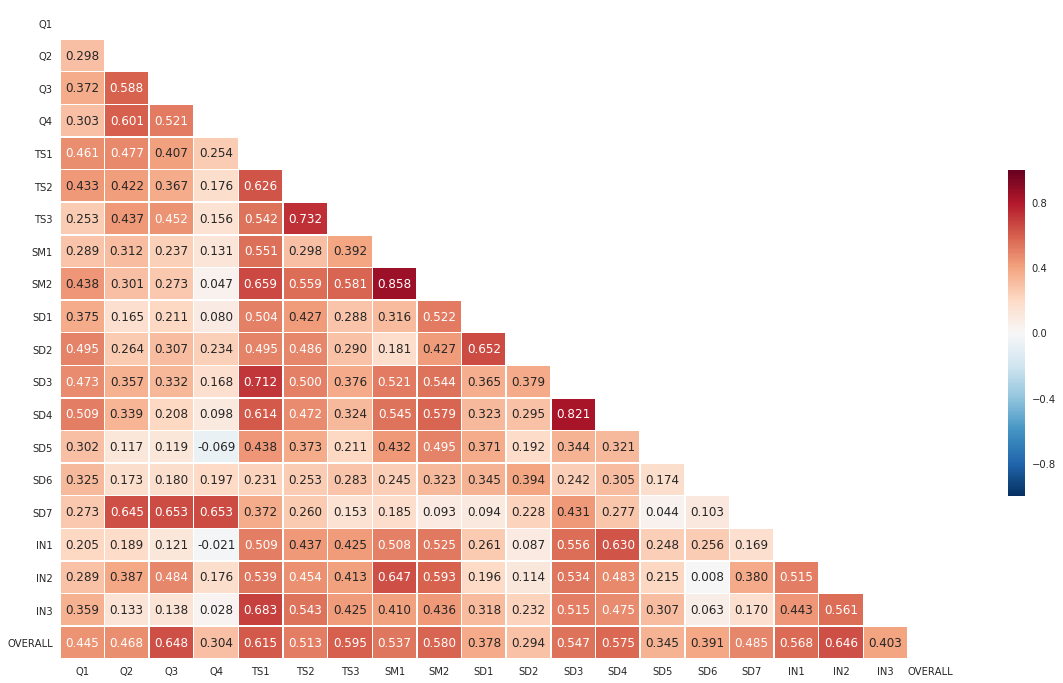

In [65]:
variables= df.iloc[:, df.columns.get_loc('Q1'):df.columns.get_loc('IN3')+1]
variables['OVERALL']= df['OVERALL']
corr= variables.corr()

sns.set(style= 'white', rc= {'figure.figsize':(20,12)})
mask= np.triu(corr)
ax_corr= sns.heatmap(corr, annot= True, fmt= '.3f', mask= mask, vmin= -1, vmax= 1, center= 0, 
            cmap= 'RdBu_r', linewidths= .5, cbar_kws= {"shrink": .5})
ax_corr.tick_params(axis ='y', rotation = 0)
sns.reset_orig()

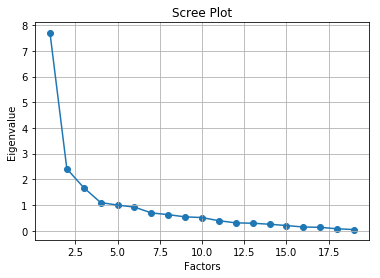

(4, array([7.71431252, 2.41087369, 1.67554549, 1.09564407, 0.99604892,
        0.9190102 , 0.69255692, 0.62413856, 0.53815764, 0.51109167,
        0.387718  , 0.30439468, 0.28992912, 0.25051133, 0.19980949,
        0.14297365, 0.1310224 , 0.07311374, 0.0431479 ]))

In [44]:
num_of_factors(variables, scree_plot= True, eigenvalue= True)

In [14]:
factor_variance, loadings, transformed_variables= factor_analysis(variables)
factor_variance
# first array: the factor variances
# second array: the proportional factor variances
# third array: the cumulative factor variances 

(array([4.78463593, 3.16836884, 2.80834056, 2.13503043]),
 array([0.25182294, 0.16675625, 0.1478074 , 0.11237002]),
 array([0.25182294, 0.4185792 , 0.5663866 , 0.67875662]))

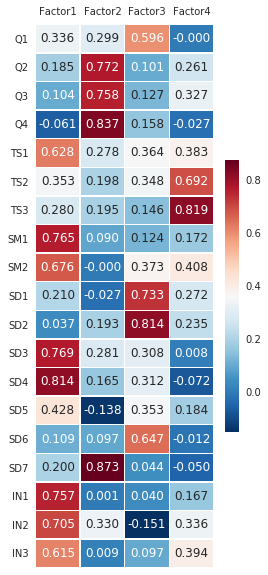

In [26]:
sns.set(style= 'white', rc= {'figure.figsize':(4,10)})
loadings_min= loadings.min().min()
loadings_max= loadings.max().max()
loadings_mid= (loadings_min + loadings_max) / 2
ax_loadings= sns.heatmap(loadings, annot= True, fmt= '.3f', vmin= loadings_min, vmax= loadings_max, 
                         center= loadings_mid, cmap= 'RdBu_r', linewidths= .5, cbar_kws= {"shrink": .5})
ax_loadings.xaxis.set_ticks_position('top')
ax_loadings.tick_params(axis ='y', rotation = 0)
sns.reset_orig()

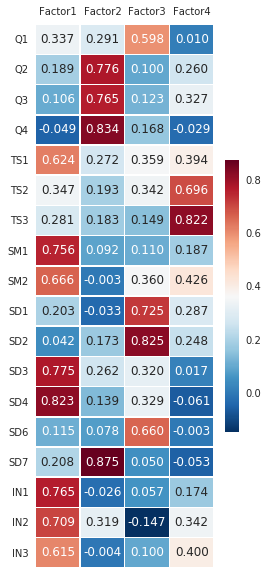

In [29]:
variables_no_SD5= variables.drop(columns=['SD5'])
factor_variance_no_SD5, loadings_no_SD5, transformed_variables_no_SD5= factor_analysis(variables_no_SD5)

sns.set(style= 'white', rc= {'figure.figsize':(4,10)})
loadings_min_no_SD5= loadings_no_SD5.min().min()
loadings_max_no_SD5= loadings_no_SD5.max().max()
loadings_mid_no_SD5= (loadings_min_no_SD5 + loadings_max_no_SD5) / 2
ax_loadings= sns.heatmap(loadings_no_SD5, annot= True, fmt= '.3f', vmin= loadings_min_no_SD5, vmax= loadings_max_no_SD5, 
                         center= loadings_mid_no_SD5, cmap= 'RdBu_r', linewidths= .5, cbar_kws= {"shrink": .5})
ax_loadings.xaxis.set_ticks_position('top')
ax_loadings.tick_params(axis ='y', rotation = 0)
sns.reset_orig()

In [32]:
factor_variance_no_SD5

(array([4.6104745 , 3.11371246, 2.71006611, 2.16507654]),
 array([0.25613747, 0.17298403, 0.15055923, 0.12028203]),
 array([0.25613747, 0.4291215 , 0.57968073, 0.69996276]))

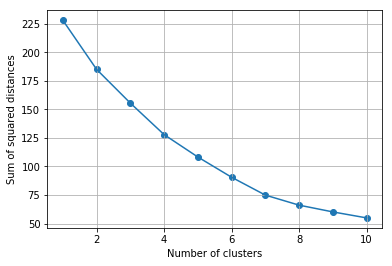

In [16]:
elbow_KMean(df[['Factor1', 'Factor2', 'Factor3', 'Factor4']])

In [19]:
transformed_variables['Overall']= df['OVERALL']

In [46]:
cluster_analysis(transformed_variables, 2, 'Factor1', 'Factor4', label= True)
transformed_variables.head()

,Factor1,Factor2,Factor3,Factor4,Overall,Segment2,Segment3,Segment4,WTE,Size,Revenue,Years,Numprod
0,-0.486313,-0.281694,0.245500,-1.547377,8.0,1,0,3,5.0,54.0,4.0,6.5,7.0
1,0.565536,0.470746,-0.322735,1.069777,10.0,0,1,0,3.0,45.0,2.0,6.0,6.0
2,0.508125,-3.421711,2.733143,-2.646283,3.0,1,0,3,2.0,44.0,2.0,5.8,11.0
3,-2.572384,0.743445,1.511659,-2.218464,7.0,1,2,2,4.0,46.0,1.0,7.0,3.0
4,0.247463,0.398252,-0.298602,-0.629235,8.0,0,1,0,5.0,46.0,3.0,6.5,8.0


Segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Overall when (Segment2 = 0): 8.783, N: 46
mean of Overall when (Segment2 = 1): 6.583, N: 12
p-value of the difference: 0.000




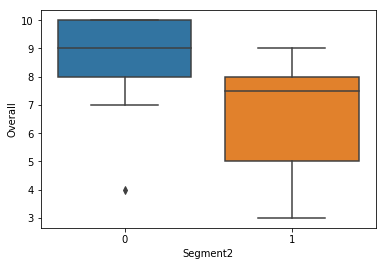

In [66]:
multi_ttest_1d(transformed_variables, 'Segment2', 'Overall', violinplot= False)

In [62]:
cluster_analysis(transformed_variables, 3, 'Factor1', 'Factor4', label= True)
transformed_variables.head()

,Factor1,Factor2,Factor3,Factor4,Overall,Segment2,Segment3,Segment4,WTE,Size,Revenue,Years,Numprod
0,-0.486313,-0.281694,0.245500,-1.547377,8.0,1,2,3,5.0,54.0,4.0,6.5,7.0
1,0.565536,0.470746,-0.322735,1.069777,10.0,0,1,0,3.0,45.0,2.0,6.0,6.0
2,0.508125,-3.421711,2.733143,-2.646283,3.0,1,0,3,2.0,44.0,2.0,5.8,11.0
3,-2.572384,0.743445,1.511659,-2.218464,7.0,1,2,2,4.0,46.0,1.0,7.0,3.0
4,0.247463,0.398252,-0.298602,-0.629235,8.0,0,1,0,5.0,46.0,3.0,6.5,8.0


Segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Overall when (Segment3 = 0): 5.000, N: 3
mean of Overall when (Segment3 = 1): 8.909, N: 44
p-value of the difference: 0.000
a = 0, b = 1, seg_max-1 = 2
Segments 0 vs. 2: no difference (fail to reject H0)
mean of Overall when (Segment3 = 0): 5.000, N: 3
mean of Overall when (Segment3 = 2): 6.909, N: 11
p-value of the difference: 0.138
a = 0, b = 2, seg_max-1 = 2
Segments 1 vs. 2: the difference is statistically significant (reject H0)
mean of Overall when (Segment3 = 1): 8.909, N: 44
mean of Overall when (Segment3 = 2): 6.909, N: 11
p-value of the difference: 0.000


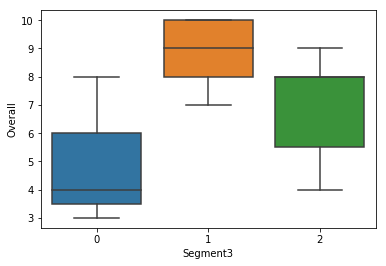

In [80]:
multi_ttest_1d(transformed_variables, 'Segment3', 'Overall', violinplot= False)

In [25]:
cluster_analysis(transformed_variables, 4, 'Factor1', 'Factor4', label= True)
transformed_variables.head()

,Factor1,Factor2,Factor3,Factor4,Overall,Segment2,Segment3,Segment4
0,-0.486313,-0.281694,0.245500,-1.547377,8.0,1,0,3
1,0.565536,0.470746,-0.322735,1.069777,10.0,0,1,0
2,0.508125,-3.421711,2.733143,-2.646283,3.0,1,0,3
3,-2.572384,0.743445,1.511659,-2.218464,7.0,1,2,2
4,0.247463,0.398252,-0.298602,-0.629235,8.0,0,1,0


Segments 0 vs. 1: no difference (fail to reject H0)
mean of Overall when (Segment4 = 0): 8.963, N: 27
mean of Overall when (Segment4 = 1): 8.550, N: 20
p-value of the difference: 0.254
a = 0, b = 1, seg_max-1 = 3
Segments 0 vs. 2: the difference is statistically significant (reject H0)
mean of Overall when (Segment4 = 0): 8.963, N: 27
mean of Overall when (Segment4 = 2): 6.667, N: 6
p-value of the difference: 0.001
a = 0, b = 2, seg_max-1 = 3
Segments 0 vs. 3: the difference is statistically significant (reject H0)
mean of Overall when (Segment4 = 0): 8.963, N: 27
mean of Overall when (Segment4 = 3): 6.000, N: 5
p-value of the difference: 0.000
a = 0, b = 3, seg_max-1 = 3
Segments 1 vs. 2: the difference is statistically significant (reject H0)
mean of Overall when (Segment4 = 1): 8.550, N: 20
mean of Overall when (Segment4 = 2): 6.667, N: 6
p-value of the difference: 0.003
a = 1, b = 2, seg_max-1 = 3
Segments 1 vs. 3: the difference is statistically significant (reject H0)
mean of Ove

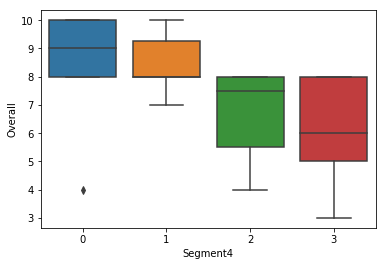

In [81]:
multi_ttest_1d(transformed_variables, 'Segment4', 'Overall', violinplot= False)

In [49]:
transformed_variables[['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Overall']].groupby(
    transformed_variables['Segment2']).agg(['mean', 'std', 'count']).round(3)

Factor1              Factor2              Factor3               \
            mean    std count    mean    std count    mean    std count   
Segment2                                                                  
0          0.319  0.622    46   0.003  0.920    46   0.011  0.767    46   
1         -1.224  1.277    12  -0.010  1.345    12  -0.043  1.693    12   

         Factor4              Overall               
            mean    std count    mean    std count  
Segment2                                            
0          0.292  0.658    46   8.783  1.228    46  
1         -1.119  1.334    12   6.583  1.929    12

In [50]:
transformed_variables.describe().round(3)

,Factor1,Factor2,Factor3,Factor4,Overall,Segment2,Segment3,Segment4,WTE,Size,Revenue,Years,Numprod
count,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000,58.000
mean,-0.000,0.000,-0.000,0.000,8.328,0.207,1.034,0.810,3.034,42.517,1.547,6.281,4.828
std,1.009,1.009,1.009,1.009,1.648,0.409,0.494,0.945,1.169,10.702,0.870,0.929,2.610
min,-3.687,-3.422,-3.560,-2.890,3.000,0.000,0.000,0.000,1.000,27.000,0.300,4.500,2.000
25%,-0.224,-0.546,-0.559,-0.304,8.000,0.000,1.000,0.000,2.000,34.000,0.900,5.500,3.000
50%,0.267,0.158,-0.078,0.155,8.000,0.000,1.000,1.000,3.000,43.000,1.000,6.500,4.000
75%,0.695,0.724,0.816,0.706,10.000,0.000,1.000,1.000,4.000,49.000,2.000,7.000,6.750
max,1.259,1.799,2.733,2.577,10.000,1.000,2.000,3.000,5.000,69.000,4.000,9.500,11.000


In [51]:
transformed_variables['WTE']= df['WTE']
transformed_variables['Size']= df['Size']
transformed_variables['Revenue']= df['Revenue']
transformed_variables['Years']= df['Years']
transformed_variables['Numprod']= df['Numprod']
transformed_variables.head()

,Factor1,Factor2,Factor3,Factor4,Overall,Segment2,Segment3,Segment4,WTE,Size,Revenue,Years,Numprod
0,-0.486313,-0.281694,0.245500,-1.547377,8.0,1,0,3,5.0,54.0,4.0,6.5,7.0
1,0.565536,0.470746,-0.322735,1.069777,10.0,0,1,0,3.0,45.0,2.0,6.0,6.0
2,0.508125,-3.421711,2.733143,-2.646283,3.0,1,0,3,2.0,44.0,2.0,5.8,11.0
3,-2.572384,0.743445,1.511659,-2.218464,7.0,1,2,2,4.0,46.0,1.0,7.0,3.0
4,0.247463,0.398252,-0.298602,-0.629235,8.0,0,1,0,5.0,46.0,3.0,6.5,8.0


In [52]:
transformed_variables[['WTE', 'Size', 'Revenue', 'Years', 'Overall']].groupby(
    transformed_variables['Segment2']).agg(['mean', 'std', 'count']).round(3)

WTE                 Size               Revenue               \
           mean    std count    mean     std count    mean    std count   
Segment2                                                                  
0         2.978  1.183    46  40.652  10.397    46   1.435  0.790    46   
1         3.250  1.138    12  49.667   8.998    12   1.975  1.055    12   

          Years              Overall               
           mean    std count    mean    std count  
Segment2                                           
0         6.261  0.880    46   8.783  1.228    46  
1         6.358  1.138    12   6.583  1.929    12

Segments 0 vs. 1: no difference (fail to reject H0)
mean of WTE when (Segment2 = 0): 2.978, N: 46
mean of WTE when (Segment2 = 1): 3.250, N: 12
p-value of the difference: 0.478


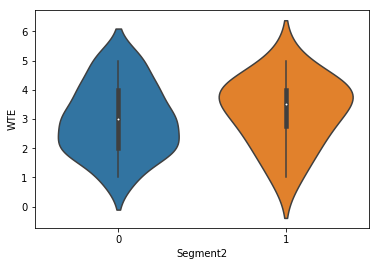

Segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Size when (Segment2 = 0): 40.652, N: 46
mean of Size when (Segment2 = 1): 49.667, N: 12
p-value of the difference: 0.008


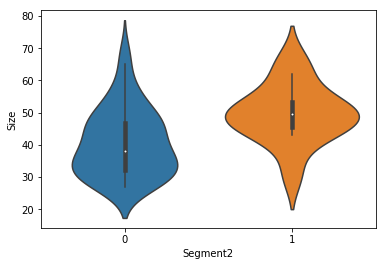

Segments 0 vs. 1: no difference (fail to reject H0)
mean of Revenue when (Segment2 = 0): 1.435, N: 46
mean of Revenue when (Segment2 = 1): 1.975, N: 12
p-value of the difference: 0.055


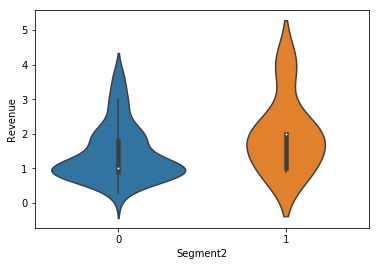

Segments 0 vs. 1: no difference (fail to reject H0)
mean of Years when (Segment2 = 0): 6.261, N: 46
mean of Years when (Segment2 = 1): 6.358, N: 12
p-value of the difference: 0.749


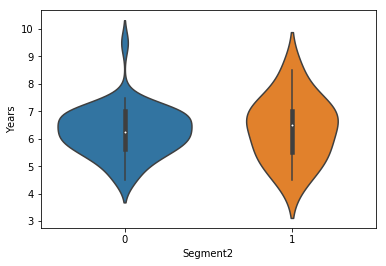

Segments 0 vs. 1: the difference is statistically significant (reject H0)
mean of Overall when (Segment2 = 0): 8.783, N: 46
mean of Overall when (Segment2 = 1): 6.583, N: 12
p-value of the difference: 0.000


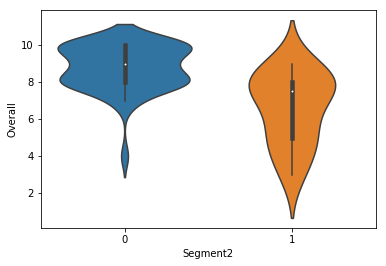

In [48]:
demo= ['WTE', 'Size', 'Revenue', 'Years', 'Overall']
for c in range(0, len(demo)):
    multi_ttest_1d(transformed_variables, 'Segment2', demo[c], violinplot= True)

Calculated from SPSS values

Segments 1 vs. 2: the difference is statistically significant (reject H0)
mean of OVERALL when (Segment2_19v = 1): 6.923, N: 13
mean of OVERALL when (Segment2_19v = 2): 8.733, N: 45
p-value of the difference: 0.000


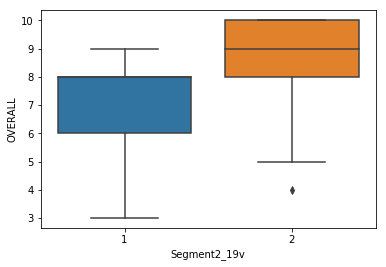

In [57]:
multi_ttest_1d(df, 'Segment2_19v', 'OVERALL')

Segments 1 vs. 2: the difference is statistically significant (reject H0)
mean of OVERALL when (Segment3_19v = 1): 6.857, N: 7
mean of OVERALL when (Segment3_19v = 2): 8.455, N: 33
p-value of the difference: 0.017


Segments 1 vs. 3: the difference is statistically significant (reject H0)
mean of OVERALL when (Segment3_19v = 1): 6.857, N: 7
mean of OVERALL when (Segment3_19v = 3): 8.667, N: 18
p-value of the difference: 0.024


Segments 2 vs. 3: no difference (fail to reject H0)
mean of OVERALL when (Segment3_19v = 2): 8.455, N: 33
mean of OVERALL when (Segment3_19v = 3): 8.667, N: 18
p-value of the difference: 0.646


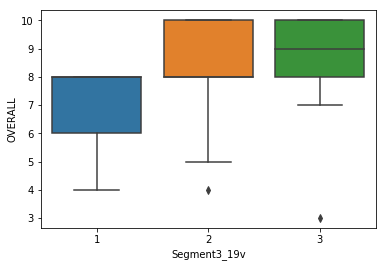

In [58]:
multi_ttest_1d(df, 'Segment3_19v', 'OVERALL')

Segments 1 vs. 2: no difference (fail to reject H0)
mean of OVERALL when (Segment4 = 1): 7.714, N: 7
mean of OVERALL when (Segment4 = 2): 8.308, N: 26
p-value of the difference: 0.406


Segments 1 vs. 3: no difference (fail to reject H0)
mean of OVERALL when (Segment4 = 1): 7.714, N: 7
mean of OVERALL when (Segment4 = 3): 5.500, N: 2
p-value of the difference: 0.250


Segments 1 vs. 4: no difference (fail to reject H0)
mean of OVERALL when (Segment4 = 1): 7.714, N: 7
mean of OVERALL when (Segment4 = 4): 8.783, N: 23
p-value of the difference: 0.089


Segments 2 vs. 3: the difference is statistically significant (reject H0)
mean of OVERALL when (Segment4 = 2): 8.308, N: 26
mean of OVERALL when (Segment4 = 3): 5.500, N: 2
p-value of the difference: 0.034


Segments 2 vs. 4: no difference (fail to reject H0)
mean of OVERALL when (Segment4 = 2): 8.308, N: 26
mean of OVERALL when (Segment4 = 4): 8.783, N: 23
p-value of the difference: 0.255


Segments 3 vs. 4: the difference is statisticall

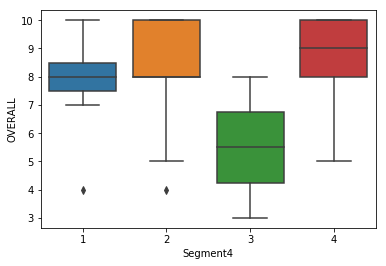

In [19]:
multi_ttest_1d(df, 'Segment4', 'OVERALL')

In [72]:
df[['Factor1_19v', 'Factor2_19v', 'Factor3_19v', 'Factor4_19v', 'OVERALL']].groupby(
    df['Segment2_19v']).agg(['mean', 'std', 'count']).round(3)

Factor1_19v              Factor2_19v              Factor3_19v  \
                    mean    std count        mean    std count        mean   
Segment2_19v                                                                 
1                 -1.297  1.217    13      -0.646  1.532    13       0.474   
2                  0.375  0.501    45       0.187  0.705    45      -0.137   

                          Factor4_19v              OVERALL               
                std count        mean    std count    mean    std count  
Segment2_19v                                                             
1             1.167    13      -0.417  1.532    13   6.923  1.891    13  
2             0.916    45       0.121  0.767    45   8.733  1.338    45

In [52]:
df[['Factor1_18v', 'Factor2_18v', 'Factor3_18v', 'Factor4_18v', 'OVERALL']].groupby(
    df['Segment2_18v']).agg(['mean', 'std', 'count']).round(3)

Factor1_18v              Factor2_18v              Factor3_18v  \
                    mean    std count        mean    std count        mean   
Segment2_18v                                                                 
1                  0.308  0.371     2      -2.990  0.832     2       1.832   
2                 -0.011  1.015    56       0.107  0.829    56      -0.065   

                          Factor4_18v              OVERALL               
                std count        mean    std count    mean    std count  
Segment2_18v                                                             
1             1.440     2       -1.13  2.016     2   5.500  3.536     2  
2             0.934    56        0.04  0.956    56   8.429  1.512    56

In [73]:
df[['WTE', 'Size', 'Revenue', 'Years', 'Numprod', 'OVERALL']].groupby(
    df['Segment2_19v']).agg(['mean', 'std', 'count']).round(3)

WTE                 Size               Revenue               \
               mean    std count    mean     std count    mean    std count   
Segment2_19v                                                                  
1             3.077  1.188    13  47.231   9.084    13   1.738  0.845    13   
2             3.022  1.177    45  41.156  10.835    45   1.491  0.878    45   

              Years              Numprod              OVERALL               
               mean    std count    mean    std count    mean    std count  
Segment2_19v                                                                
1             6.446  1.019    13   5.538  2.602    13   6.923  1.891    13  
2             6.233  0.908    45   4.622  2.605    45   8.733  1.338    45

In [54]:
df[['WTE', 'Size', 'Revenue', 'Years', 'OVERALL']].groupby(
    df['Segment2_18v']).agg(['mean', 'std', 'count']).round(3)

WTE                 Size               Revenue               \
               mean    std count    mean     std count    mean    std count   
Segment2_18v                                                                  
1             2.000  0.000     2  46.500   3.536     2   1.500  0.707     2   
2             3.071  1.173    56  42.375  10.857    56   1.548  0.880    56   

              Years              OVERALL               
               mean    std count    mean    std count  
Segment2_18v                                           
1             5.650  0.212     2   5.500  3.536     2  
2             6.304  0.937    56   8.429  1.512    56

Segments 1 vs. 2: no difference (fail to reject H0)
mean of WTE when (Segment2_19v = 1): 3.077, N: 13
mean of WTE when (Segment2_19v = 2): 3.022, N: 45
p-value of the difference: 0.883


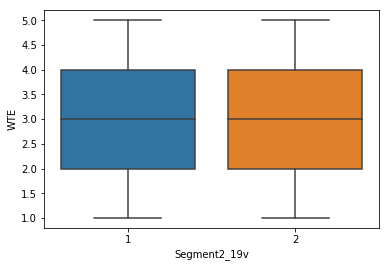

Segments 1 vs. 2: no difference (fail to reject H0)
mean of Size when (Segment2_19v = 1): 47.231, N: 13
mean of Size when (Segment2_19v = 2): 41.156, N: 45
p-value of the difference: 0.071


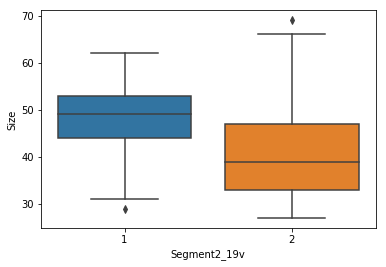

Segments 1 vs. 2: no difference (fail to reject H0)
mean of Revenue when (Segment2_19v = 1): 1.738, N: 13
mean of Revenue when (Segment2_19v = 2): 1.491, N: 45
p-value of the difference: 0.371


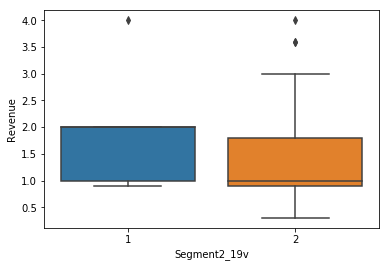

Segments 1 vs. 2: no difference (fail to reject H0)
mean of Years when (Segment2_19v = 1): 6.446, N: 13
mean of Years when (Segment2_19v = 2): 6.233, N: 45
p-value of the difference: 0.472


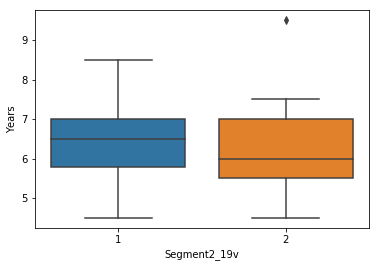

Segments 1 vs. 2: no difference (fail to reject H0)
mean of Numprod when (Segment2_19v = 1): 5.538, N: 13
mean of Numprod when (Segment2_19v = 2): 4.622, N: 45
p-value of the difference: 0.269


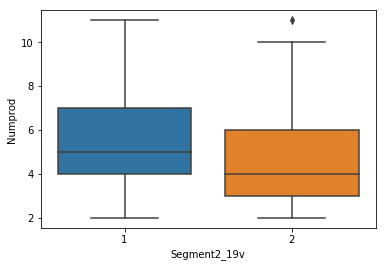

In [71]:
demo= ['WTE', 'Size', 'Revenue', 'Years', 'Numprod']
for c in range(0, len(demo)):
    multi_ttest_1d(df, 'Segment2_19v', demo[c])

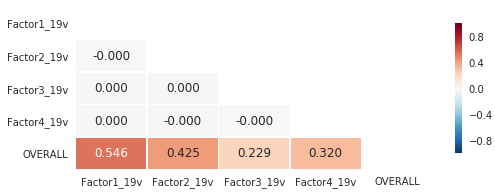

In [14]:
profile= df[['Factor1_19v', 'Factor2_19v', 'Factor3_19v', 'Factor4_19v', 'OVERALL']]
corr= profile.corr()

sns.set(style= 'white', rc= {'figure.figsize':(8,3)})
mask= np.triu(corr)
ax_corr= sns.heatmap(corr, annot= True, fmt= '.3f', mask= mask, vmin= -1, vmax= 1, center= 0, 
            cmap= 'RdBu_r', linewidths= .5, cbar_kws= {"shrink": .8})
ax_corr.tick_params(axis ='y', rotation = 0)
sns.reset_orig()